In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('sample_workbook.xlsx', index_col=0)
df.fillna('None', inplace=True)

In [2]:
df

,A,B,C,D,E,F,G
Activity,,,,,,,
Prerequisites,None,None,A,"A,B",D,"C,E",E
Completion Time,9.0,5.0,8,4,5,3,7


In [3]:
#initializes a matrix for each activity to store es, ls, ef, and lf
def init_activity_matrix(df):
    activities = df.columns.values.tolist()
    activity_catalogue = {}
    for activity in activities:
        activity_catalogue[activity] = pd.DataFrame({'es':[],'ls':[],'ef':[],'lf':[]})
    return activity_catalogue

def forward_pass(df, activity_catalogue):
    activities = df.columns
    for activity in activities:
        #gets completion time
        completion_time = df.loc['Completion Time', activity]
        if df.loc['Prerequisites',activity] == 'None':
            activity_catalogue[activity]['es'] = [0]
            activity_catalogue[activity]['ef'] = [completion_time]
            continue
        
        prerequisites = [prequisite.strip() for prequisite in df.loc['Prerequisites', activity].split(',')]
        #get least es from pre req
        es_values = [float(activity_catalogue[prerequisite]['ef'][0]) for prerequisite in prerequisites]
        if len(es_values) > 1:
            es_values.sort()
        es_value = es_values[-1]
        activity_catalogue[activity]['es'] = [es_value]
        activity_catalogue[activity]['ef'] = [es_value + completion_time]
    return activity_catalogue

def get_forward_reference(df):
    activities = df.columns.values

    forward_reference= {}
    for activity in activities:
        forward_reference[activity]=[]
        for check in activities:
            if activity in df.loc['Prerequisites',check].split(','):
                forward_reference[activity].append(check)
    return forward_reference

def backward_pass(df, activity_catalogue):
    activities = df.columns.values
    
    def backward_pass_variables(df):
        activities = df.columns.tolist()
        end_nodes = []
        all_predecessors = [df.loc['Prerequisites', activity].split(',') for activity in activities if [df.loc['Prerequisites', activity]] != ['None'] ]
        unique_predecessors=[]
        for predecessor_list in all_predecessors:
            for predecessor in predecessor_list:
                if predecessor not in unique_predecessors:
                    unique_predecessors.append(predecessor)

        for activity in activities:
            if activity not in unique_predecessors:
                end_nodes.append(activity)
        return end_nodes
    
    end_nodes = backward_pass_variables(df)
    lf_values_end_nodes = [activity_catalogue[end_node]['ef'][0] for end_node in end_nodes]
    if len(lf_values_end_nodes) > 1:
        lf_values_end_nodes.sort()
    lf_value_end_nodes= lf_values_end_nodes[-1]
    
    next_batch = []
    for end_node in end_nodes:
        activity_catalogue[end_node]['lf']=[lf_value_end_nodes]
        activity_catalogue[end_node]['ls']=[lf_value_end_nodes-df.loc['Completion Time', end_node]]
        prerequisites = df.loc['Prerequisites',end_node].split(',')                                            
        for prerequisite in prerequisites :
            next_batch.append(prerequisite)
    
    forward_reference = get_forward_reference(df)
            
    while True:
        if len(next_batch)==0:
            break
        current_batch = next_batch
        next_batch=[]
        for activity in current_batch:
            if activity == 'None':
                continue
            forward_values = forward_reference[activity]
            completion_time = df.loc['Completion Time', activity]
            if len(forward_values)>1:
                lf_value = [activity_catalogue[value]['ls'][0] for value in forward_values]
                lf_value = np.array(lf_value).min()
                activity_catalogue[activity]['lf'] = [lf_value]
                activity_catalogue[activity]['ls']=[lf_value-completion_time]
            else:
                forward_values = forward_reference[activity]
                activity_catalogue[activity]['lf'] = activity_catalogue[forward_values[0]]['ls']
                activity_catalogue[activity]['ls']=[activity_catalogue[activity]['lf'][0]-completion_time]
            
            for prerequisite in df.loc['Prerequisites',activity].split(','):
                if prerequisite == 'Npne':
                    continue
                next_batch.append(prerequisite)
    return activity_catalogue

def graph(activity_catalogue):
    def concat_matrix(activity_catalogue):
        main_matrix = activity_catalogue[[key for key in activity_catalogue.keys()][0]].loc[1:0]
        for activity in activity_catalogue:
            main_matrix.loc[activity] = activity_catalogue[activity].iloc[0,:]
        return main_matrix

    concatenated_catalogue = concat_matrix(activity_catalogue)

    fig, gnt = plt.subplots(figsize=[21,9])

    tick_length = df.columns.values

    step=20

    activities = df.columns.values.tolist()

    tick_length = np.arange(0,stop=len(activities)*step, step = step) + step
    gnt.set_yticks(tick_length)
    gnt.set_yticklabels(concatenated_catalogue.index.values)
    gnt.set_ylim(top=tick_length[-1]+step)

    indexes = concatenated_catalogue.index.values
    for count,index in enumerate(indexes):
        es_value = float(concatenated_catalogue.loc[index,'es'])
        ls_value = float(concatenated_catalogue.loc[index,'ls'])
        ef_value = float(concatenated_catalogue.loc[index,'ef'])
        lf_value = float(concatenated_catalogue.loc[index,'lf'])
        gnt.broken_barh([(es_value, lf_value-es_value)], (tick_length[count]-step/4, 10),color='#93F9EC')
        gnt.broken_barh([(ls_value, ef_value-ls_value)], (tick_length[count]-step/4, 10),color='#07F7D7')
        gnt.text((es_value+lf_value)/2,tick_length[count]+8,f'{es_value},{ls_value} - {ef_value},{lf_value}',ha='center', size=8)

        gnt.set_xlabel('Days')
    gnt.set_ylabel('Activity')
    gnt.set_title('PERT/CPM')
    plt.draw()

def catalogue_rename(dct):
    for key in list(dct.keys()):
        dct[key].columns =['Earliest Start', 'Latest Start', 'Earliest Finish', 'Latest Finish']
        dct[key].index = [key]
    return dct

def run(df):
    activity_catalogue = init_activity_matrix(df)
    activity_catalogue = forward_pass(df,activity_catalogue)
    activity_catalogue = backward_pass(df,activity_catalogue)
    graph(activity_catalogue)
    activity_catalogue = catalogue_rename(activity_catalogue)
    return activity_catalogue

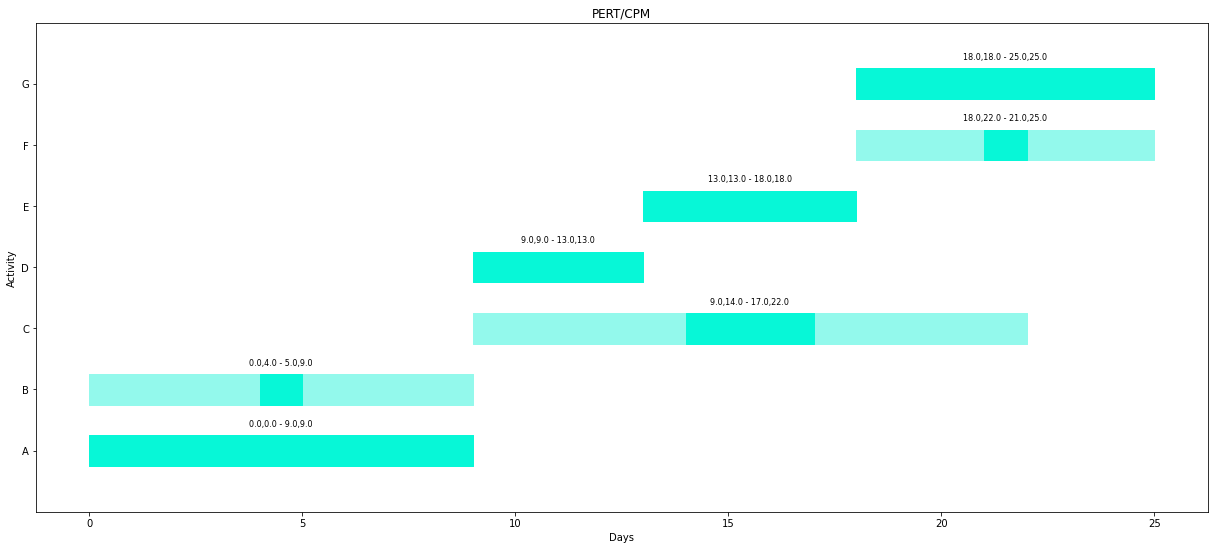

In [4]:
activity_catalogue = run(df)

In [5]:
pd.concat(activity_catalogue.values())

,Earliest Start,Latest Start,Earliest Finish,Latest Finish
A,0.0,0.0,9.0,9.0
B,0.0,4.0,5.0,9.0
C,9.0,14.0,17.0,22.0
D,9.0,9.0,13.0,13.0
E,13.0,13.0,18.0,18.0
F,18.0,22.0,21.0,25.0
G,18.0,18.0,25.0,25.0
